### makemore: lect03


### day14

- 202403120630--202403120800
- 202403122000--202403122100

### day 15
- 202403130845--202403131200
  
### day 16
- 202403140630--20240314?

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Any

### Constants

In [2]:
RANDOM_SEED = 10
NUM_BLOCKS = 3
NUM_DIM_CHARS = 2
NUM_HIDDEN = 20

### Random Generator

In [3]:
import random
import numpy as np

rand_gen = torch.Generator().manual_seed(RANDOM_SEED)
RAND_GEN = rand_gen

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Read File

In [4]:
words = open("names.txt").read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

### Make Mappings: `chr -> int` and `int -> chr`

In [5]:
ord("a"), ord("z"), ord("z") - ord("a") + 1, chr(ord("a")), chr(ord("z"))

(97, 122, 26, 'a', 'z')

In [6]:
itos = {i - ord("a") + 1: chr(i) for i in range(ord("a"), ord("z") + 1)}
itos[0] = "."

stoi = {s: i for i, s in itos.items()}

# stoi
# itos

In [7]:
chars = sorted(list(set("".join(words))))
chars[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [8]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

### Get Data

In [9]:
def get_data(words: List[str], num_blocks: int = 3, stoi=stoi) -> (List[torch.tensor], List[torch.tensor]):
    """get data"""

    X, Y = [], []


    ### tese lines are for testing:
    # for word in words[:5]:
        # print("-" * 80)

    for word in words:
        context = [0] * num_blocks
        for ch in word + ".":
            i = stoi[ch]
            # append the current char ch, i.e. the index i into Y;
            # at the same time append the current context into X;
            # (the context up to now) contains letters that preeced the char ch
            # print(" ".join((itos[ix] for ix in context)), "--->", ch)
            X.append(context)
            Y.append(i)
            context = context[1: ] + [i]
           

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [10]:
get_data(words)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [11]:
num_blocks = NUM_BLOCKS
X, Y = get_data(words, num_blocks=num_blocks)

In [12]:
X[:10]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])

In [13]:
Y[:10]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])

### Split Data: `train`, `val/dev`, and `test`

In [14]:
X.shape, X.shape[0]

(torch.Size([228146, 3]), 228146)

In [15]:
Y.shape, Y.shape[0]

(torch.Size([228146]), 228146)

In [16]:
indexes = torch.randperm(X.shape[0], generator=rand_gen)
indexes[:10]

tensor([117017,  81926, 152774,   8097, 220660,  38770, 226753, 147220, 224337,
        175417])

In [17]:
# this list changes over time?!
torch.randperm(X.shape[0], generator=rand_gen)[:10]

tensor([184694,  31158,  21725,  15842,   3894,  75184,  50599, 156241, 116075,
         47106])

In [18]:
def split_data(X, y, split=0.8):
    
    """split data into train, val, and test sets"""
    
    assert X.shape[0] == y.shape[0], "input data X and Y sizes do not match."
    assert (0 < split and split < 1), "the split for training data should be within (0, 1)."
    
    len_data = X.shape[0]
    shuffled_indices = torch.randperm(X.shape[0], generator=rand_gen)

    len_train = int(split * len_data)
    len_val = (len_data - len_train) // 2
    len_test = len_data - len_train - len_val
    
    
    X_train = X[shuffled_indices][:len_train]
    X_val = X[shuffled_indices][len_train: len_train + len_val]
    X_test = X[shuffled_indices][- len_test:]
    
    y_train = Y[shuffled_indices][:len_train]
    y_val = Y[shuffled_indices][len_train: len_train + len_val]
    y_test = Y[shuffled_indices][- len_test:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [19]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

In [20]:
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

### MLP revisted

### Develop Model

- `C` is a mapping that translates `chars` into a `dim`-dimensional vector space;

In [21]:
### given the context X; 
### we predict the following char given in Y; 
### and the prediction belongs in one out of 27 classes; 
### i.e. there are 27 chars as a possibility for it. 

vocab_size = 27 

In [392]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * num_blocks, n_hidden), generator=g) * (5 /3) / ((n_embed * num_blocks) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.2
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

12297


### Pay attention about shapes

In [364]:
hpreact.shape

torch.Size([32, 200])

In [327]:
torch.randn((5, ), generator=rand_gen)

tensor([1.0568, 0.1018, 0.7585, 0.7507, 2.6994])

In [328]:
torch.randn(5, generator=rand_gen)

tensor([-1.3669,  0.6406, -0.5534,  0.4189, -0.1302])

In [329]:
torch.randn((5, 1), generator=rand_gen)

tensor([[ 1.3098],
        [-0.5295],
        [ 0.5699],
        [ 0.7339],
        [ 0.7348]])

### Optimization

In [330]:
X_train.shape[0]

182516

In [331]:
# mini-batch construct
batch_size = 32
ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
# print(i, ix)
X_batch, Y_batch = X_train[ix], Y_train[ix]
X_batch.shape

torch.Size([32, 3])

In [332]:
# C: 27 x 10 
# X_batch: 32 x 3 

emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [333]:
emb.view(emb.shape[0], -1).shape

torch.Size([32, 30])

In [334]:
X_batch

tensor([[ 9,  1,  8],
        [ 0,  0, 14],
        [ 5,  2,  5],
        [ 0,  0,  0],
        [ 1, 14,  4],
        [ 5, 18, 19],
        [ 0,  0,  4],
        [14,  5, 14],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [12,  5, 25],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0, 25, 21],
        [15, 14, 14],
        [21, 19,  5],
        [ 1, 12,  5],
        [19, 25, 14],
        [ 0,  0,  0],
        [ 0,  0, 12],
        [21, 13,  9],
        [ 1, 18, 11],
        [12,  9,  1],
        [ 9, 14, 20],
        [ 0,  0,  0],
        [ 0,  0, 26],
        [ 7, 18,  1],
        [ 0,  0, 10],
        [18,  1, 14],
        [ 0,  3, 15],
        [20,  9,  1],
        [ 5,  1, 22]])

In [335]:
C.shape

torch.Size([27, 10])

In [336]:
C[0].shape

torch.Size([10])

In [337]:
C[X_batch[2]].shape

torch.Size([3, 10])

In [338]:
X_batch[2]

tensor([5, 2, 5])

In [339]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)

In [340]:
C[19]

tensor([-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
        -0.4528, -0.4958], grad_fn=<SelectBackward0>)

In [341]:
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830], grad_fn=<SelectBackward0>)

In [342]:
C[[0, 19, 5]]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
         -0.4528, -0.4958],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]], grad_fn=<IndexBackward0>)

In [343]:
C[X_batch[2]]

tensor([[ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830],
        [ 0.9849, -0.1484, -1.4795,  0.4483, -0.0707,  2.4968,  2.4448, -0.6701,
         -1.2199,  0.3031],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]], grad_fn=<IndexBackward0>)

In [344]:
emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [345]:
emb_cat = emb.view(emb.shape[0], -1)
emb_cat.shape

torch.Size([32, 30])

In [346]:
W1.shape

torch.Size([30, 200])

In [347]:
h = emb_cat @ W1 + b1
h.shape

torch.Size([32, 200])

In [348]:
W2.shape

torch.Size([200, 27])

In [349]:
(h @ W2).shape

torch.Size([32, 27])

In [350]:
b2.shape

torch.Size([27])

In [351]:
Y_batch.shape

torch.Size([32])

In [352]:
X.shape

torch.Size([228146, 3])

In [370]:
X_batch.shape, emb.shape, emb_cat.shape, W1.shape, hpreact.shape, W2.shape, logits.shape

(torch.Size([32, 3]),
 torch.Size([32, 3, 10]),
 torch.Size([32, 30]),
 torch.Size([30, 200]),
 torch.Size([32, 200]),
 torch.Size([200, 27]),
 torch.Size([32, 27]))

In [374]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [383]:
hpreact.mean(0, keepdim=True)[0][0], hpreact[:,0].sum()/32

(tensor(-0.1230, grad_fn=<SelectBackward0>),
 tensor(-0.1230, grad_fn=<DivBackward0>))

In [384]:
hpreact.mean(1, keepdim=True).shape

torch.Size([32, 1])

In [387]:
hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [388]:
hpreact.mean(0, keepdim=True)

tensor([[-0.1230, -0.5873, -0.8543,  0.5450,  0.6782,  0.4143,  1.2484, -0.7872,
         -0.6211,  0.1020, -0.5287, -1.0402,  0.0771,  0.4690, -0.0138, -0.2756,
          0.1982, -1.1569, -1.1289,  0.7166,  0.1459, -0.6268,  0.6169,  0.1708,
          0.5244, -0.0482,  0.2954, -0.1689, -0.3929,  0.8022, -0.4908, -0.7372,
         -0.1558,  0.1935, -0.4598, -0.7233, -0.3043, -0.5087, -0.7272,  0.3853,
         -0.1598, -1.1077, -0.7300, -0.1692,  0.1821, -0.1266, -0.3834, -0.4358,
          0.3095,  0.8430,  0.3897, -0.0781,  0.8120,  0.7437,  0.5612, -0.8401,
         -0.2233,  1.2066,  0.7427, -0.3252, -0.3139,  0.5793,  0.3497, -0.1774,
          1.0549,  0.6487,  0.5680, -0.1351, -0.3529,  0.4218, -0.8260,  1.0311,
          0.7847, -0.3717, -0.9606, -0.4936,  0.9245, -0.0385, -0.0886, -0.1654,
         -0.0898,  1.0482,  0.1119,  0.2480,  0.3371, -0.1919, -0.5748, -0.0329,
          0.1840, -0.5366,  0.7334,  0.4897, -0.9554, -0.0518, -0.6660, -0.9959,
         -0.7445, -0.1616, -

In [389]:
hpreact.std(0, keepdim=True)

tensor([[1.8069, 0.9428, 1.4674, 1.2714, 1.5799, 1.2015, 1.0440, 0.9566, 1.7329,
         0.9726, 1.5896, 1.1925, 1.1497, 1.5780, 1.0579, 1.4973, 2.2707, 1.0362,
         1.0632, 1.2428, 1.2259, 1.5688, 1.1214, 1.9241, 1.2268, 1.2892, 1.1865,
         1.5352, 2.2300, 1.4074, 1.0902, 1.0301, 1.9646, 1.2645, 1.8769, 1.2006,
         1.3213, 1.7574, 1.4629, 1.2667, 0.9733, 1.5178, 1.2917, 2.1447, 1.1661,
         1.1086, 1.4272, 1.3864, 0.8441, 1.3798, 1.1551, 1.0146, 0.9473, 1.2784,
         1.4341, 1.3234, 1.0804, 1.9139, 2.1588, 1.2108, 1.1653, 1.1095, 0.8624,
         1.3413, 1.3956, 1.3323, 1.5515, 1.2580, 1.3223, 1.8983, 1.6233, 1.6244,
         1.1667, 1.0162, 1.0142, 1.4580, 1.5888, 1.7145, 1.6259, 1.2756, 2.0895,
         1.4544, 1.5600, 1.7993, 1.4331, 1.5498, 1.0237, 1.2297, 1.2409, 1.2752,
         1.2051, 1.3977, 1.4640, 2.3779, 2.0947, 1.4357, 1.7304, 1.3945, 1.0062,
         1.3557, 1.4847, 1.6872, 2.0325, 1.3610, 0.8818, 1.0810, 1.5025, 1.2762,
         1.3235, 1.5059, 1.4

In [353]:
max_steps = 1000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation

    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # backward pass: 
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad
        
    
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    # break


     40 /    1000; 3.2325
     80 /    1000; 2.6161
    120 /    1000; 2.7384
    160 /    1000; 2.7674
    200 /    1000; 2.2351
    240 /    1000; 2.9261
    280 /    1000; 2.7155
    320 /    1000; 2.6209
    360 /    1000; 2.4392
    400 /    1000; 3.0918
    440 /    1000; 2.8006
    480 /    1000; 2.6262
    520 /    1000; 2.1993
    560 /    1000; 2.4847
    600 /    1000; 2.2694
    640 /    1000; 2.4845
    680 /    1000; 2.6063
    720 /    1000; 2.5543
    760 /    1000; 2.5359
    800 /    1000; 2.1631
    840 /    1000; 2.0999
    880 /    1000; 2.4681
    920 /    1000; 2.4787
    960 /    1000; 2.4866
   1000 /    1000; 2.3494


In [354]:
h, h.shape

(tensor([[ 0.9024, -0.8630, -0.9727,  ..., -0.9592, -0.1367,  0.9597],
         [-0.3740, -0.6643,  0.6896,  ..., -0.9793,  0.9633,  0.9995],
         [ 0.1461, -0.7377, -0.9718,  ..., -0.9894,  0.9458,  0.9958],
         ...,
         [-0.8854,  0.0179, -0.9575,  ..., -0.8676,  0.8035,  0.3138],
         [-0.0301, -0.9810, -0.9945,  ...,  0.7309,  0.2106, -0.6074],
         [-0.9563,  0.2307, -0.5137,  ..., -0.3874,  0.9661,  0.9738]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

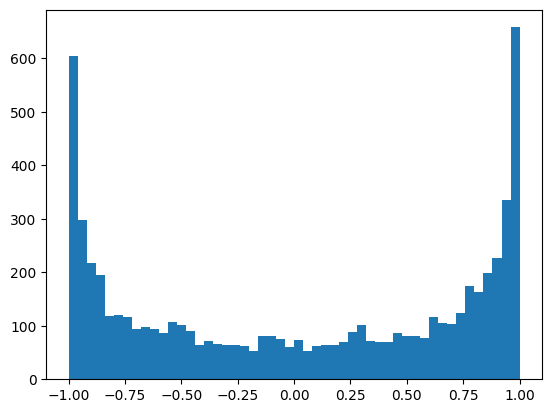

In [355]:
plt.hist(h.view(-1).tolist(), 50);

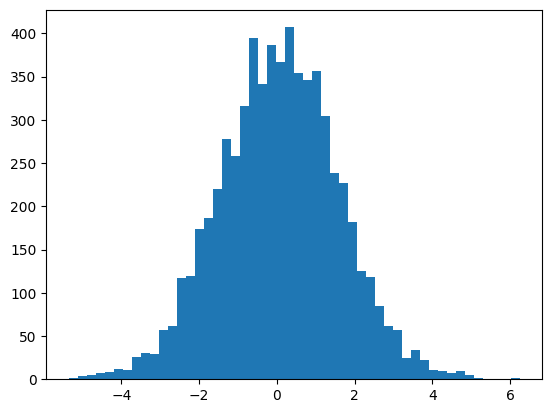

In [356]:
plt.hist(hpreact.view(-1).tolist(), 50);

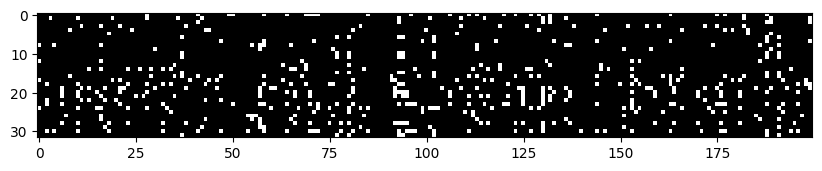

In [357]:
plt.figure(figsize=(10, 20))
plt.imshow(h.abs() >= 0.99, cmap="gray", interpolation="nearest")

### White = 1, True; and Black = 0 False;

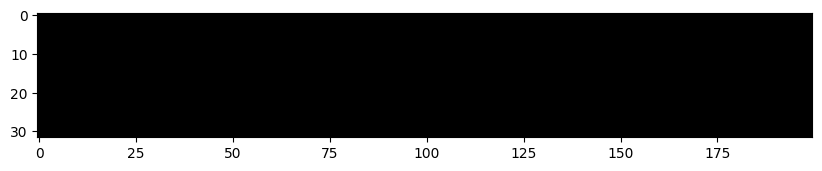

In [358]:
plt.figure(figsize=(10, 20))
plt.imshow(0 * h.abs() >= 0.99, cmap="gray", interpolation="nearest")

In [359]:
h.shape, hpreact.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

In [360]:
lossi[:10]

[5.22398567199707,
 4.9029035568237305,
 4.814296722412109,
 4.871747016906738,
 4.252354145050049,
 3.7364706993103027,
 3.9188549518585205,
 3.957167148590088,
 3.860842227935791,
 3.8980870246887207]

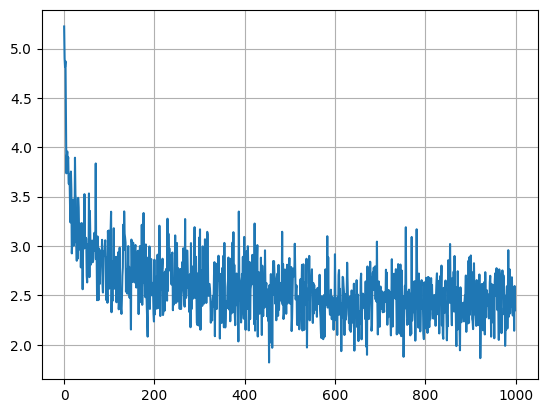

In [361]:
plt.plot(lossi)
plt.grid(True)

In [362]:
logits[0]

tensor([ 0.4486,  2.5683, -1.2992, -1.2617, -0.7357,  3.0664, -2.8948, -0.4666,
        -0.3286,  2.2480, -2.5368, -2.1696, -0.4548,  1.5566, -0.2071,  1.7689,
         0.1650, -3.1802,  3.4540, -0.6641, -0.9446,  1.1028, -1.0540, -0.3115,
        -3.7060,  1.2663, -1.5581], grad_fn=<SelectBackward0>)

In [296]:
probs = torch.softmax(logits[0], dim=0)
probs.sum()
# plt.imshow()

tensor(1., grad_fn=<SumBackward0>)

In [297]:
probs = torch.softmax(logits, dim=1)

In [279]:
probs.shape

torch.Size([32, 27])

In [280]:
probs[0].shape, probs[0].sum(), probs[1].shape, probs[1].sum()

(torch.Size([27]),
 tensor(1., grad_fn=<SumBackward0>),
 torch.Size([27]),
 tensor(1.0000, grad_fn=<SumBackward0>))

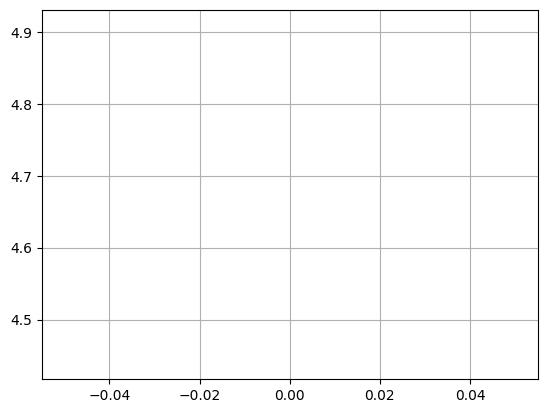

In [282]:
@torch.no_grad()
def evaluate(split: str):

    data_map = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }

    
    x, y = data_map[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{split = }, {loss.item() = }")

In [283]:
evaluate("train")    
evaluate("val")    
evaluate("test")    

split = 'train', loss.item() = 4.4398698806762695
split = 'val', loss.item() = 4.44188928604126
split = 'test', loss.item() = 4.441650390625


In [95]:
# sample from the model 
rg = torch.Generator().manual_seed(RANDOM_SEED + 10)

for t in range(20):
    out = []
    context = [0] * NUM_BLOCKS
    while True:
        # emb = C[torch.tensor([context])]
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs_test = F.softmax(logits)
        probs = F.softmax(logits, dim=1)
    
        ix = torch.multinomial(probs, num_samples=1, generator=rg)
        ch = itos[ix.item()]
        # print(ch)  
        context = context[1:] + [ix]
        out.append(ix)
    
        if ix == 0:
            break
    print(t, "".join(itos[i.item()] for i in out))
    
    # print("".join()

0 kerson.
1 nesh.
2 parlon.
3 reni.
4 kas.
5 caifordri.
6 fivia.
7 eir.
8 meani.
9 altculeeghayni.
10 kenaay.
11 tor.
12 fraexe.
13 dianis.
14 liziasganittewah.
15 cedda.
16 seid.
17 amryssavalsyn.
18 gettoldernille.
19 asty.


/tmp/ipykernel_29624/1897569945.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_test = F.softmax(logits)


In [94]:
emb = C[torch.tensor(context)]

In [64]:
emb.shape

torch.Size([3, 10])

In [66]:
emb.view(1, -1).shape

torch.Size([1, 30])

In [63]:
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [71]:
probs_t.shape

torch.Size([1, 27])

In [72]:
probs.shape

torch.Size([1, 27])

In [74]:
probs_t.sum()

tensor(1., grad_fn=<SumBackward0>)

In [75]:
logits.shape

torch.Size([1, 27])

In [125]:
logits = torch.tensor([100.0, 0.0, 0.0, 0.0])
logits = torch.rand(4) * 100
probs = torch.softmax(logits, dim=0)

In [126]:
probs

tensor([9.9908e-01, 3.2862e-13, 9.2450e-04, 2.8196e-08])

In [127]:
loss = - probs[2].log()

In [128]:
logits, probs, loss

(tensor([61.7796, 33.0366, 54.7942, 44.3964]),
 tensor([9.9908e-01, 3.2862e-13, 9.2450e-04, 2.8196e-08]),
 tensor(6.9863))

In [313]:
torch.randn(10).shape

torch.Size([10])

In [325]:
for i in range(10):
    r = torch.randn(100)
    print(# r.mean().item(), 
          r.std().item())

0.9087595343589783
0.9427216053009033
1.2110837697982788
1.1623538732528687
1.019275188446045
1.0205391645431519
1.1242066621780396
1.078918695449829
0.9643968343734741
0.9453296065330505
